In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import warnings 
warnings.filterwarnings('ignore')
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller,acf,pacf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from sklearn.metrics import mean_squared_error 
import statsmodels.api as sm
import seaborn as sns

In [3]:
df1=pd.read_csv(r"C:\Users\anant\Downloads\DS3_C1_S3_DailyDelhiClimateTrain_Data_Practice.csv",index_col="date",parse_dates=True)
data=df1['meantemp']
data

date
2013-01-01    10.000000
2013-01-02     7.400000
2013-01-03     7.166667
2013-01-04     8.666667
2013-01-05     6.000000
                ...    
2016-12-28    17.217391
2016-12-29    15.238095
2016-12-30    14.095238
2016-12-31    15.052632
2017-01-01    10.000000
Name: meantemp, Length: 1462, dtype: float64

In [4]:
data.isnull().sum()

0

### Visualising the data

<AxesSubplot:xlabel='date'>

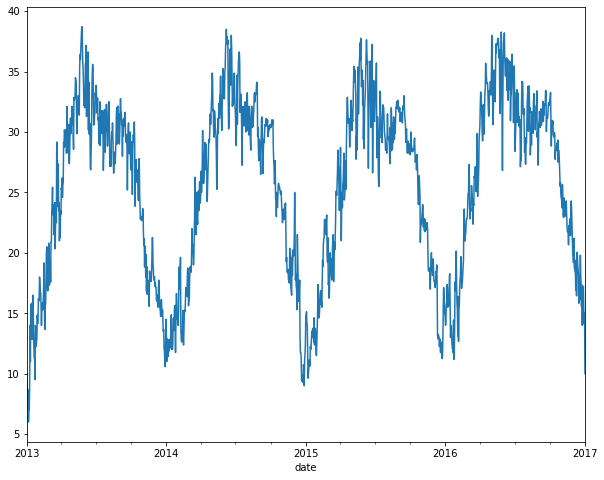

In [5]:
data.plot(figsize=(10,8))

### Observation:
No trend but seasonality is observed

### Smoothing of the data using Moving Average

In [6]:
lags=7
ma_lag7 = data.rolling(window=lags).mean()

In [7]:
df_ma = pd.DataFrame({'actual':data, 'ma_lag7':ma_lag7})
print(df_ma)

               actual    ma_lag7
date                            
2013-01-01  10.000000        NaN
2013-01-02   7.400000        NaN
2013-01-03   7.166667        NaN
2013-01-04   8.666667        NaN
2013-01-05   6.000000        NaN
...               ...        ...
2016-12-28  17.217391  16.480592
2016-12-29  15.238095  16.188075
2016-12-30  14.095238  15.980252
2016-12-31  15.052632  15.656602
2017-01-01  10.000000  15.085173

[1462 rows x 2 columns]


In [8]:
lags = 30 
ma_lag30 = data.rolling(window=lags).mean()

In [9]:
lags = 14 
ma_lag14 = data.rolling(window=lags).mean()

In [10]:
df_ma['ma_lag14']=ma_lag14

In [11]:
df_ma['ma_lag30']=ma_lag30

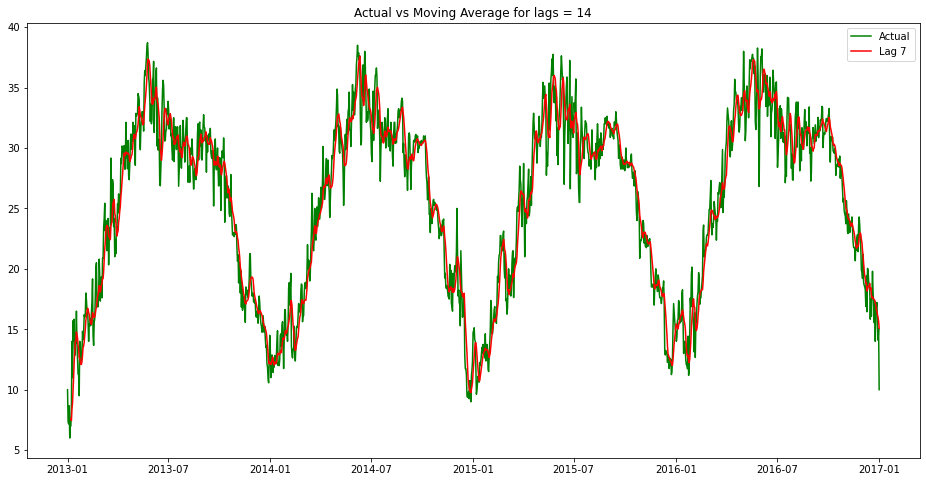

In [12]:
_,ax = plt.subplots(figsize=(16,8))
plt.plot(df_ma.actual, color='green',label = 'Actual')
plt.plot(df_ma.ma_lag7, color='red', label = 'Lag 7') 
#plt.plot(df_ma.ma_lag30,color='blue',label='Lag 30')
#plt.plot(df_ma.ma_lag14,color='yellow',label='Lag 14')
plt.title('Actual vs Moving Average for lags = ' + str(lags)) 
plt.legend() 
plt.show()

In [13]:
df=df_ma['ma_lag7']

In [14]:
df=df.dropna()

In [15]:
df

date
2013-01-07     7.604762
2013-01-08     7.441497
2013-01-09     8.384354
2013-01-10     8.931973
2013-01-11     9.938776
                ...    
2016-12-28    16.480592
2016-12-29    16.188075
2016-12-30    15.980252
2016-12-31    15.656602
2017-01-01    15.085173
Name: ma_lag7, Length: 1456, dtype: float64

### Checking the Stationarity

### Hypothesis:  
H0: p-value < 0.05 Data is stationary. Model can be built.  
Ha: p-value > 0.05 Data is not stationary.  

In [16]:
def checkStationarity(data): 
    pvalue = adfuller(data)[1] 
    ''' 
    output:-> 1) test statistic,
    2) p-value, 
    3) number of lags,
    4) total observations 
    dfoutput = pd.Series(result[0:4],index=['tstat','pvalue','lags','obs']) 
    pvalue = dfoutput['pvalue'] 
    ''' 
    if(pvalue>0.05): 
        msg = 'p-value={}. Data is not stationary'.format(pvalue) 
    else: 
        msg='p-value={}. Data is stationary'.format(pvalue) 
    return(msg)

In [17]:
checkStationarity(df)

'p-value=0.07252386116400802. Data is not stationary'

<AxesSubplot:xlabel='date'>

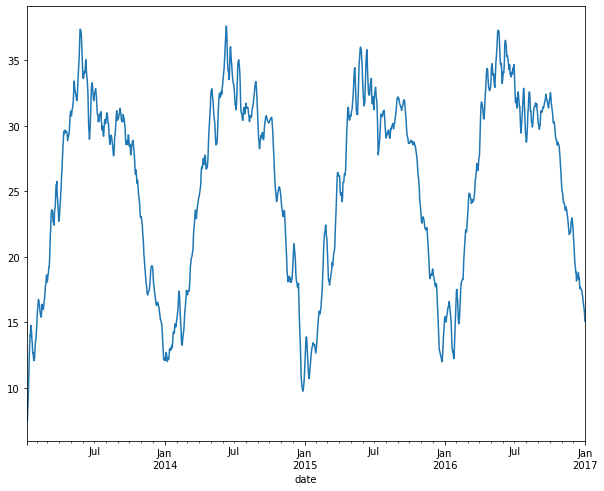

In [18]:
df.plot(figsize=(10,8))

### Observation:
As the data is not stationary shifting of the data is done

### Data Shifting

In [19]:
df_diff = df.diff()

In [20]:
df_diff

date
2013-01-07         NaN
2013-01-08   -0.163265
2013-01-09    0.942857
2013-01-10    0.547619
2013-01-11    1.006803
                ...   
2016-12-28   -0.118944
2016-12-29   -0.292517
2016-12-30   -0.207823
2016-12-31   -0.323650
2017-01-01   -0.571429
Name: ma_lag7, Length: 1456, dtype: float64

In [21]:
df_diff=df_diff.dropna()
checkStationarity(df_diff)

'p-value=4.186610393547038e-06. Data is stationary'

# Reading test data and checking stationarity

In [22]:
df2=pd.read_csv(r'C:\Users\anant\Downloads\DS3_C1_S3_DailyDelhiClimateTest_Data_Practice.csv',index_col="date",parse_dates=True)
data1=df2['meantemp']
data1

date
2017-01-01    15.913043
2017-01-02    18.500000
2017-01-03    17.111111
2017-01-04    18.700000
2017-01-05    18.388889
                ...    
2017-04-20    34.500000
2017-04-21    34.250000
2017-04-22    32.900000
2017-04-23    32.875000
2017-04-24    32.000000
Name: meantemp, Length: 114, dtype: float64

In [23]:
data1.isnull().sum()

0

In [24]:
checkStationarity(data1)

'p-value=0.7164758731775932. Data is not stationary'

In [25]:
test_diff = data1.diff()

In [26]:
test_diff=test_diff.dropna()
checkStationarity(test_diff)

'p-value=2.8053213689778235e-22. Data is stationary'

### Plotting of ACF and PACF Plots

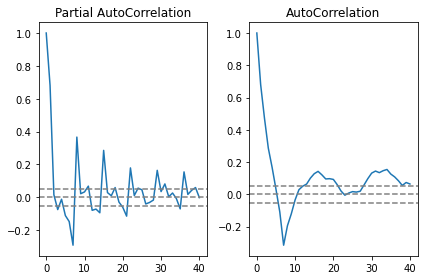

In [27]:
lag_acf = acf(df_diff, nlags=40) 
lag_pacf = pacf(df_diff, nlags=40 , method='ols') 

# plot PACF (p)

plt.subplot(121)
plt.plot(lag_pacf) 
plt.axhline(y=0,linestyle='--',color="gray") 
plt.axhline(y=-1.96/np.sqrt(len(df_diff)),linestyle='--',color="gray")
plt.axhline(y=1.96/np.sqrt(len(df_diff)),linestyle='--',color="gray") 
plt.title("Partial AutoCorrelation")

# plot ACF (q)

plt.subplot(122)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color="gray") 
plt.axhline(y=-1.96/np.sqrt(len(df_diff)),linestyle='--',color="gray") 
plt.axhline(y=1.96/np.sqrt(len(df_diff)),linestyle='--',color="gray") 
plt.title("AutoCorrelation") 

plt.tight_layout()

### Building of ARMA model using Initial Values

In [28]:
p=1; q=1
m1 = ARIMA(df,order=(p,0,q)).fit() 
print(m1.summary())

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


                               SARIMAX Results                                
Dep. Variable:                ma_lag7   No. Observations:                 1456
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -537.209
Date:                Tue, 01 Feb 2022   AIC                           1082.418
Time:                        17:00:55   BIC                           1103.552
Sample:                    01-07-2013   HQIC                          1090.303
                         - 01-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         21.2296      5.981      3.549      0.000       9.507      32.953
ar.L1          0.9986      0.001    705.440      0.000       0.996       1.001
ma.L1          0.5089      0.020     25.413      0.0

### Predicting using Test data

In [29]:
predictions = m1.predict(0,len(data1)-1) 
print(predictions)

2013-01-07    21.229630
2013-01-08     7.615107
2013-01-09     7.390231
2013-01-10     8.882372
2013-01-11     8.973776
                ...    
2013-04-26    29.095849
2013-04-27    29.499480
2013-04-28    29.405582
2013-04-29    30.078963
2013-04-30    30.759245
Freq: D, Name: predicted_mean, Length: 114, dtype: float64


In [35]:
actual = []; pred = [] 
for i in range(len(predictions)):
    actual.append(data1[i]) 
    pred.append(predictions[i]) 
df_res = pd.DataFrame({'actual':actual, 'predicted':pred}) 
df_res['err'] = df_res.actual - df_res.predicted
print(df_res)

        actual  predicted        err
0    15.913043  21.229630  -5.316586
1    18.500000   7.615107  10.884893
2    17.111111   7.390231   9.720880
3    18.700000   8.882372   9.817628
4    18.388889   8.973776   9.415113
..         ...        ...        ...
109  34.500000  29.095849   5.404151
110  34.250000  29.499480   4.750520
111  32.900000  29.405582   3.494418
112  32.875000  30.078963   2.796037
113  32.000000  30.759245   1.240755

[114 rows x 3 columns]


In [36]:
mse1 = mean_squared_error(df_res.actual,df_res.predicted) 
print('RMSE: ' + str(np.sqrt(mse1) ))

RMSE: 3.808987441975948


### Plot the errors

<AxesSubplot:>

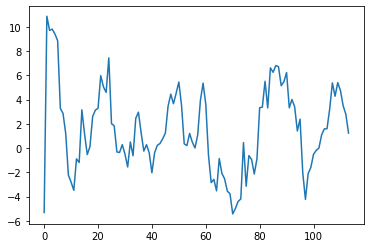

In [31]:
df_res.err.plot()

<AxesSubplot:xlabel='err', ylabel='Count'>

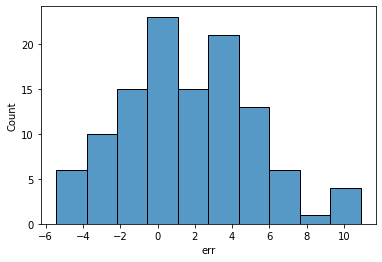

In [32]:
sns.histplot(df_res['err'])

In [33]:
df_res['err'].describe()

count    114.000000
mean       1.527762
std        3.504578
min       -5.434461
25%       -0.629430
50%        1.206086
75%        3.603305
max       10.884893
Name: err, dtype: float64

### Building the model using diff p and q values

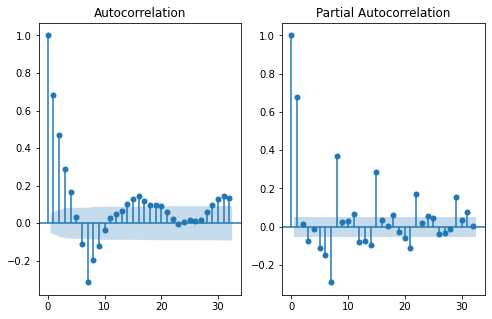

In [151]:
fig,ax=plt.subplots(1,2,figsize=(8,5))
plot_acf(df_diff,ax=ax[0])
plot_pacf(df_diff,ax=ax[1])
plt.show()

In [152]:
p=15; q=16
m2 = ARIMA(df_diff,order=(p,0,q)).fit() 
print(m2.summary())

                               SARIMAX Results                                
Dep. Variable:                ma_lag7   No. Observations:                 1455
Model:               ARIMA(15, 0, 16)   Log Likelihood                  78.764
Date:                Mon, 31 Jan 2022   AIC                            -91.527
Time:                        18:04:11   BIC                             82.804
Sample:                    01-08-2013   HQIC                           -26.483
                         - 01-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.036      0.063      0.950      -0.068       0.072
ar.L1          0.4720      1.667      0.283      0.777      -2.796       3.740
ar.L2          0.1724      1.965      0.088      0.9

In [154]:
predictions1 = m2.predict(0,len(test_diff)-1) 
print(predictions1)

2013-01-08    0.002255
2013-01-09   -0.109148
2013-01-10    0.617575
2013-01-11    0.427329
2013-01-12    0.643699
                ...   
2013-04-26    0.426782
2013-04-27   -0.131855
2013-04-28    0.445643
2013-04-29    0.413094
2013-04-30    0.469267
Freq: D, Name: predicted_mean, Length: 113, dtype: float64


In [155]:
actual = []; pred = [] 
for i in range(len(predictions1)):
    actual.append(test_diff[i]) 
    pred.append(predictions1[i]) 
df_res1 = pd.DataFrame({'actual':actual, 'predicted':pred}) 
df_res1['err'] = df_res1.actual - df_res1.predicted
print(df_res1)

       actual  predicted       err
0    2.586957   0.002255  2.584701
1   -1.388889  -0.109148 -1.279741
2    1.588889   0.617575  0.971314
3   -0.311111   0.427329 -0.738440
4    0.929293   0.643699  0.285594
..        ...        ...       ...
108  1.000000   0.426782  0.573218
109 -0.250000  -0.131855 -0.118145
110 -1.350000   0.445643 -1.795643
111 -0.025000   0.413094 -0.438094
112 -0.875000   0.469267 -1.344267

[113 rows x 3 columns]


<AxesSubplot:>

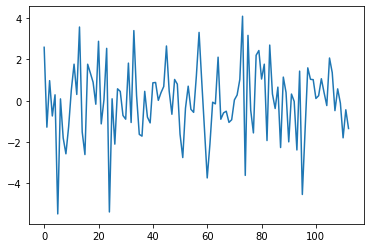

In [156]:
df_res1.err.plot()

<AxesSubplot:xlabel='err', ylabel='Count'>

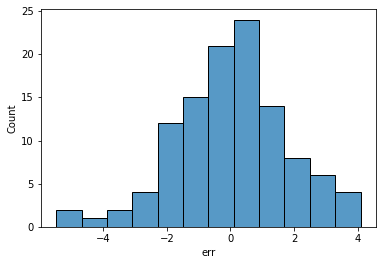

In [157]:
sns.histplot(df_res1['err'])

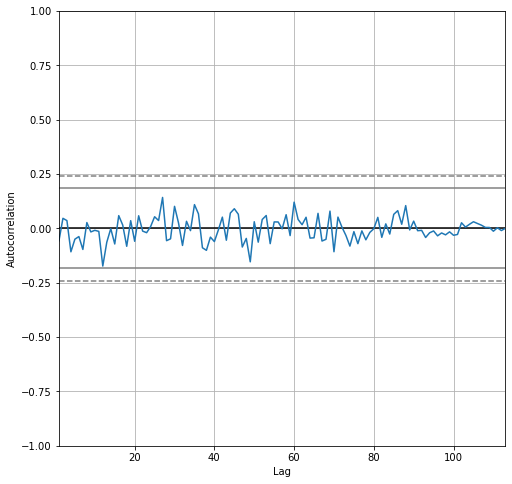

In [161]:
fig,ax=plt.subplots(figsize=(8,8))
pd.plotting.autocorrelation_plot(df_res.err)
plt.show()

In [164]:
df_res1['err'].describe()

count    113.000000
mean      -0.014503
std        1.769150
min       -5.477795
25%       -1.053431
50%        0.092821
75%        1.028664
max        4.087935
Name: err, dtype: float64

### Observation:

Model: ARIMA(1, 0, 1)  
AIC -- 753.866  
BIC -- 774.997  
HQIC -- 761.750  

Model: ARIMA(15, 0, 16)  
AIC  --  -91.527  
BIC   --    82.804  
HQIC  --   -26.483  

### Conclusion:
we can observe that the values are decreased in the model where p value is 15 and q value is 16  

## Perform the LJung-Box test

### LJung-Box test(helps to identify whether the model is acceptable or not)

### Hypothesis:  
H0: Model is good and acceptable  
Ha: Model is bad and not acceptable  

In [138]:
pvalue = sm.stats.acorr_ljungbox(m1.resid,lags=[1],return_df=True)['lb_pvalue'].values 
if pvalue < 0.05: 
    print("Reject H0. Bad model") 
else:
    print("Fail-to-Reject H0. Good model")

Fail-to-Reject H0. Good model


### Calculate MSE and RMSE of the Model from the test

In [34]:
msg = 'ARMA Model. Order=(' + str(p) + ',' + str(q) + ')' 
mse1 = mean_squared_error(df_res.actual, df_res.predicted) 
print(msg + "\n\tMSE = {}\n\tRMSE = {}".format(mse1,np.sqrt(mse1)))

ARMA Model. Order=(1,1)
	MSE = 14.508385333130475
	RMSE = 3.808987441975948


### Plot the actual data and predicted data

Text(0.5, 1.0, 'ARMA Model. Order=(1,1)')

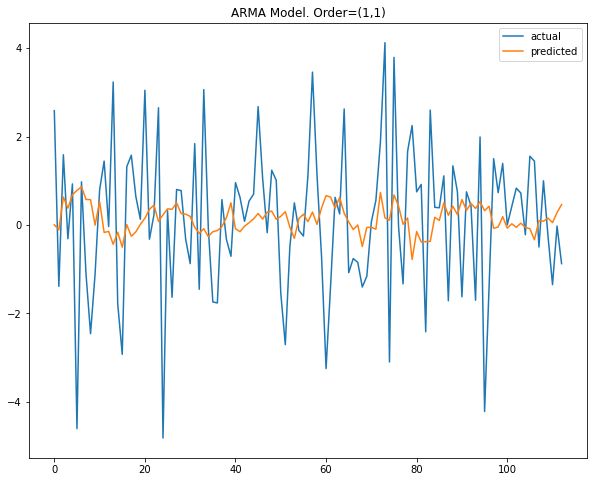

In [140]:
df_res.actual.plot(figsize=(10,8),legend=True) 
df_res.predicted.plot(legend=True) 
plt.title(msg)